In [1]:
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import copy as cp
import cmocean

#+____IMPORT FESOM RELATET ROUTINES____________________________________________+
from set_inputarray  import *
from sub_fesom_mesh  import * 
from sub_fesom_data  import * 
from sub_fesom_plot  import *
from sub_climatology  import *
from colormap_c2c    import *


#+____STUFF FOR FESOM1.4 PYFESOM PLOTTING______________________________________+
import sys
sys.path.append("/home/ollie/pscholz/pyfesom/")

from netCDF4 import Dataset, MFDataset
import pyfesom as pf

from sub_regriding_adapt import *
    
#import numpy as np
#from mpl_toolkits.basemap import Basemap
#import matplotlib.pylab as plt
#import numpy as np
#%matplotlib inline
#from matplotlib import cm

cartopy is not avalible, plotting will not work


In [ ]:
#+_________________________________________________________________________+
#|  DEFINE FUNCTION: PLOT MAP                                              |
#+_________________________________________________________________________+
def plot_map(ax,data,inputarray,clevel,cmap,xlabels,ylabels,str_title,str_ylabel):
    #______________________________________________________________________
    map = Basemap(projection=data.proj,resolution=resolution, \
                  llcrnrlon=inputarray['which_box'][0], urcrnrlon=inputarray['which_box'][1], \
                  llcrnrlat=inputarray['which_box'][2], urcrnrlat=inputarray['which_box'][3],\
                  area_thresh=10000,ax=ax,suppress_ticks=True)
    #______________________________________________________________________
    data_plot = np.copy(data.anom)
    data_plot = np.ma.masked_where(np.isnan(data_plot), data_plot)
    data_plot[data_plot<clevel[ 0]] = clevel[ 0]+np.finfo(np.float32).eps
    data_plot[data_plot>clevel[-1]] = clevel[-1]-np.finfo(np.float32).eps
    hp=ax.contourf(data.lon,data.lat,data_plot,levels=clevel,antialiased=False,extend='both',cmap=cmap)
    #______________________________________________________________________________
    map.drawmeridians(xticks,labels=xlabels,linewidth=0.25,dashes=[1,1e-10],fontsize=10)
    map.drawparallels(yticks,labels=ylabels,linewidth=0.25,dashes=[1,1e-10],fontsize=10)
    map.drawmapboundary(fill_color='0.9',linewidth=1.0)
    map.drawcoastlines(color='k',linewidth=0.5)
    map.fillcontinents(color='0.6')
    #______________________________________________________________________
    for im in ax.get_images(): im.set_clim(clevel[0],clevel[-1])
    if len(str_title)!=0  : ax.set_title(str_title , fontsize=12)
    if len(str_ylabel)!=0 : ax.set_ylabel(str_ylabel, fontsize=12)    
    #______________________________________________________________________
    return(ax,hp)

#+_________________________________________________________________________+
#|  DEFINE FUNCTION: FESOM1.4 INTERPLATION                                 |
#+_________________________________________________________________________+
def fesom14_load_data_horiz(mesh14,data_in,which_var):
    value, depdiv = np.zeros((mesh14.n2d,)), np.zeros((mesh14.n2d,))
    for yr in range(data_in.year[0],data_in.year[1]+1):
        fl         = Dataset(data_in.path+  data_in.runid+'.'+str(yr)+'.oce.mean.nc')
        value_mean = fl.variables[which_var][:,:].mean(axis=0)
        #__________________________________________________________________
        for dep in data2.depth:
            #______________________________________________________________
            # do depth interpolation 
            idx_up,idx_dwn  = np.where(mesh14.zlevs<=dep)[0][-1],np.where(mesh14.zlevs>=dep)[0][0]
            if idx_up==idx_dwn:
                value_dep, elem_no_nan = pf.get_data(value_mean,mesh14,mesh14.zlevs[idx_up] ,verbose=False)
            else:
                value_up,  elem_no_nan = pf.get_data(value_mean,mesh14,mesh14.zlevs[idx_up] ,verbose=False)
                value_dwn, elem_no_nan = pf.get_data(value_mean,mesh14,mesh14.zlevs[idx_dwn],verbose=False)
                deltaz,deltaz_i = abs(mesh14.zlevs[idx_dwn])-abs(mesh14.zlevs[idx_up]), abs(mesh14.zlevs[idx_dwn])-dep
                value_dep = value_dwn-(value_dwn-value_up)*deltaz_i/deltaz 
            #_____________________________________________________________ 
            depdiv = depdiv + np.array(np.isnan(value_dep)==False).astype('int')
            value[np.isnan(value_dep)==False] = value[np.isnan(value_dep)==False] + value_dep[np.isnan(value_dep)==False]
    #_____________________________________________________________________
    value[depdiv!=0],value[depdiv==0] = value[depdiv!=0]/depdiv[depdiv!=0], np.nan
    #_____________________________________________________________________
    return(value)

#+_________________________________________________________________________+
#|  DEFINE FUNCTION: WOA05 CLIMATOLOGY ANOMALY                             |
#+_________________________________________________________________________+
#def clim_anom_woa05(clim,data1,data2):
def clim_anom_woa05(clim,data):    
    #_____________________________________________________________________
    # calculate anomaly climatology to fesom2.0
    data11            = cp.deepcopy(clim)
    
    data_clim1        = clim_vinterp(data11,data.depth)
    mlon,mlat         = np.meshgrid(data11.lon, data11.lat)
    
    data11.str_dep    = data.str_dep
    distances1, inds1 = create_indexes_and_distances(mesh, mlon, mlat,k=10, n_jobs=2)
    data_fesom1       = fesom2regular(data.value, mesh, mlon, mlat, distances=distances1, inds=inds1, radius_of_influence=100000)
    data_fesom1       = data_fesom1.data
    data_fesom1[np.isnan(data_clim1)]=np.nan
    data11.anom       = data_fesom1-data_clim1
    data11.descript   = data.descript+'-'+'WOA05'
    return(data11)

def clim_anom_woa05_2(clim,data):  
    #_____________________________________________________________________
    # calculate anomaly climatology to fesom1.4
    data21            = cp.deepcopy(clim)
    data_clim1        = clim_vinterp(data21,data.depth)
    mlon,mlat         = np.meshgrid(data11.lon, data21.lat)
    
    data21.str_dep    = data.str_dep
    distances2, inds2 = pf.create_indexes_and_distances(mesh14, mlon, mlat,k=10, n_jobs=2)
    data_fesom2       = pf.fesom2regular(data.value, mesh14, mlon, mlat, distances=distances2, inds=inds2, radius_of_influence=100000)
    data_fesom2       = data_fesom2.data
    data_fesom2[np.isnan(data_clim1)]=np.nan
    data21.anom       = data_fesom2-data_clim1
    data21.descript   = data.descript+'-'+'WOA05'
    #_____________________________________________________________________
    #return(data11,data21)
    return(data21)


In [2]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** LOAD FVSOM MESH ***                             |
#|                                                                             |
#+_____________________________________________________________________________+
# for more options look in set_inputarray.py
inputarray=set_inputarray()
inputarray['save_fig'        ] = True
    
# set plot box for cyl projection (default: [-180,180,-90,90])
inputarray['which_box'] = [-180,180,-90,90]

# set projection variable --> the lon/lat projection plot ranges are set via 
inputarray['proj'     ] = 'cyl' # 'ortho', 'cyl', 'npstere' , 'spstere'

inputarray['mesh_id'		 ] = 'COREv2'
which_btopo = 'meanval'
inputarray['mesh_dir'		 ] = '/work/ollie/pscholz/mesh_fesom2.0/mesh_CORE2_dsidorenko_'+which_btopo+'/'
try:
	mesh
except NameError:
    mesh = fesom_init_mesh(inputarray)
else:
	print(" --> ___FOUND FESOM MESH --> will use it!___________________________")
    
    
meshpath14  ='/work/ollie/pscholz/results_fesom1.4/mesh/CORE2/'
mesh14 = pf.load_mesh(meshpath14, usepickle=False)    


___LOAD FESOM MESH COREv2_________________________________________
 --> read grid files
     > nod2d.out  : #2dn=126858
     > elem2d.out : #2de=244659
     > aux3d.out
     > nlvls.out
     > elvls.out
 --> rotate mesh rot2geo
 --> remove cyclic boundary
_______________________________________________________________
Load 2d part of the grid in 17 second(s)
Load 3d part of the grid in 15 seconds


<IPython.core.display.Javascript object>


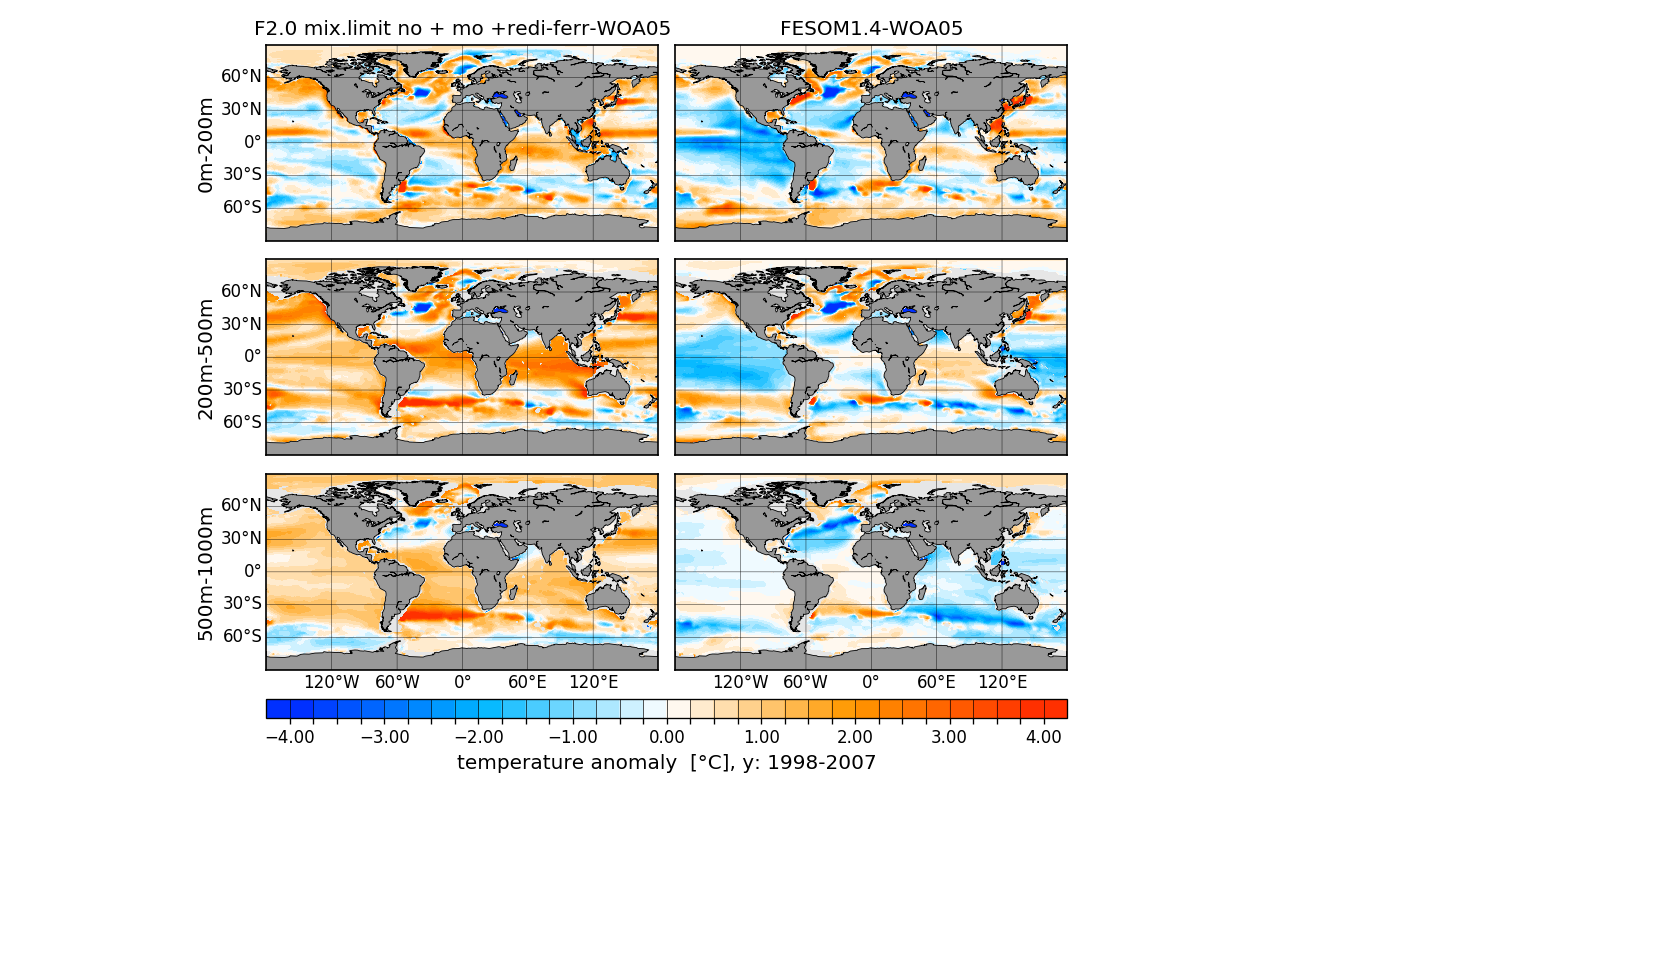

/home/ollie/pscholz/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in less
/home/ollie/pscholz/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in greater


 --> save figure: png


In [5]:
#+_________________________________________________________________________+
#|IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII|
#|LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL|
#+-------------------------------------------------------------------------+
which_var   = 'temp'
which_cycle = 1
inputarray['save_figpath'    ] = '/home/ollie/pscholz/figures/tuning/'+which_var.lower()+'/'

#_________________________________________________________________________________________________________________________
data1 		 	= fesom_data(inputarray) # init fesom2.0 data object
data1.runid     = 'fesom'
#data1.descript,data1.path       = 'F2.0 old with redi bug' ,'/work/ollie/pscholz/results_fesom2.0/linfs/z'+which_btopo+'/'+str(which_cycle)+'/'
#data1.descript,data1.path       = 'F2.0 mix.limit no' ,'/work/ollie/dsidoren/results/CORE2/ref/gm_redi_11_kpp_old/'+str(which_cycle)+'/'
#data1.descript,data1.path       = 'F2.0 mix.limit no + mo' ,'/work/ollie/dsidoren/results/CORE2/ref/gm_redi_11_kpp_old_mo/'+str(which_cycle)+'/'
#data1.descript,data1.path       = 'F2.0 mix.limit yes + mo' ,'/work/ollie/dsidoren/results/CORE2/ref/gm_redi_11_kpp_mo/'+str(which_cycle)+'/'
#data1.descript,data1.path       = 'F2.0 mix.limit yes + mo +redi' ,'/work/ollie/dsidoren/results/CORE2/ref/gm_redi_11_kpp_mo_Ferreira/'+str(which_cycle)+'/'
#data1.descript,data1.path       = 'F2.0 mix.limit yes + mo +redi-ferr' ,'/work/ollie/dsidoren/results/CORE2/ref/gm_redi_11_kpp_mo_Ferreira/'+str(which_cycle)+'/'
data1.descript,data1.path       = 'F2.0 mix.limit no + mo +redi-ferr' ,'/work/ollie/dsidoren/results/CORE2/ref/gm_redi_11_kpp_mo_old_Ferreira/'+str(which_cycle)+'/'
data1.var 		= which_var

data1.cmap, data1.cnumb = 'grads', [25]
data1.year		= [1998,2007]
data1.month		= [1,2,3,4,5,6,7,8,9,10,11,12]
#data1.month		= [9]

#_________________________________________________________________________________________________________________________
data2           = cp.deepcopy(data1);
data2.runid     = 'FEMv1'
data2.descript  = 'FESOM1.4'
data2.path      = '/work/ollie/pscholz/results_fesom1.4/nice_new/'+str(which_cycle)+'/'

#_________________________________________________________________________________________________________________________
# LOAD WOA CLIMATOLOGY
clim_path  = '../view/woa2005/'
clim_fname = 'woa2005TS.nc'
clim  = clim_data(clim_path,clim_fname,data1.var)
clim.descript = data1.descript+'-'+'WOA05'
#clim.descript = data.descript+'-'+clim.descript
#clim.descript = data.descript
clim.crange,clim.cmap, clim.cnumb      = data1.crange,data1.cmap, data1.cnumb
clim.str_time, clim.str_dep            = data1.str_time, data1.str_dep
clim.sname, clim.lname, clim.unit      = data1.sname, data1.lname, data1.unit
clim.proj, clim.proj_lon, clim.proj_lat= data1.proj, data1.proj_lon, data1.proj_lat

#+_________________________________________________________________________+
#|IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII|
#|LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL|
#+-------------------------------------------------------------------------+
fig= plt.figure(figsize=[14,8])
resolution = 'c'
fsize = 10
nrow, ncol = 4, 2

#___________________________________________________________________________    
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9,wspace=0.025, hspace=0.025)

#___________________________________________________________________________
nlabel =6;
step=np.array([5.0,10.0,15.0,30.0,45.0,60.0])
idx = np.array(np.where(step>=(inputarray['which_box'][1]-inputarray['which_box'][0])/nlabel)[0])
if idx.size==0 : idx = np.array([step.size-1])
stepx=step[idx[0]]
idx = np.array(np.where(step>=(inputarray['which_box'][3]-inputarray['which_box'][2])/nlabel)[0])
if idx.size==0 : idx = np.array([step.size-1])
stepy=step[idx[0]]
xticks , yticks =np.arange(-180.+stepx,180.,stepx), np.arange(-90.+stepy,90.-stepy+1,stepy)
xlabels, ylabels=[0,0,0,1], [1,0,0,0]

#___________________________________________________________________________
cnumb = 20; # minimum number of colors
if which_var=='salt':
    cmin,cmax,cref  = -0.5,0.5,0 # [cmin, cmax, cref] --> salt
elif which_var=='temp':
    cmin,cmax,cref  = -4.0,4.0,0 # [cmin, cmax, cref] --> temp
elif all_var=='MLD2' or all_var=='MLD1':     
    #cmin,cmax,cref  = -1000,1000,0 # [cmin, cmax, cref]  --> MLD2
    cmin,cmax,cref  = -2500,2500,0 # [cmin, cmax, cref]  --> MLD2
elif which_var=='norm_uv':    
    #cmin,cmax,cref  = -0.15,0.15,0 # [cmin, cmax, cref]  --> MLD2
    cmin,cmax,cref  = -0.1,0.1,0 # [cmin, cmax, cref]  --> MLD2
cref = 0.0
cmap1,clevel1= colormap_c2c(cmin,cmax,cref,cnumb,'blue2red')
do_drawedges=True
if clevel1.size>30: do_drawedges=False    


#__________________________________________________________________________
#IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
#LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
# calc FESOM2.0 mean over depth and time
data1.depth	  = np.arange(   0, 200+1,10)
fesom_load_data_horiz(mesh,data1,do_output=False)
# calc FESOM1.4 mean over depth and time
data2.depth   = data1.depth
data2.value   = fesom14_load_data_horiz(mesh14,data2,which_var)
# calculate anomaly climatology
#data11,data21 = clim_anom_woa05(clim,data1,data2)
data11 = clim_anom_woa05(clim,data1)
data21 = clim_anom_woa05_2(clim,data2)
# plot axes 1 & 2
ax1           = plt.subplot(3,2,1)    
ax1,hp1       = plot_map(ax1,data11,inputarray,clevel1,cmap1,[],ylabels,data11.descript,data11.str_dep[7::]+'\n\n')
ax2           = plt.subplot(3,2,2)    
ax2,hp2       = plot_map(ax2,data21,inputarray,clevel1,cmap1,[],[]     ,data21.descript,[])
  
#__________________________________________________________________________
#IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
#LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
# calc FESOM2.0 mean over depth and time
data1.depth	  = np.arange(   200, 500+1,10)
fesom_load_data_horiz(mesh,data1,do_output=False)
# calc FESOM1.4 mean over depth and time
data2.depth   = data1.depth
data2.value   = fesom14_load_data_horiz(mesh14,data2,which_var)    
# calculate anomaly climatology
#data11,data21 = clim_anom_woa05(clim,data1,data2)
data11 = clim_anom_woa05(clim,data1)
data21 = clim_anom_woa05_2(clim,data2)
# plot axes 3 & 4
ax3           = plt.subplot(3,2,3)    
ax3,hp3       = plot_map(ax3,data11,inputarray,clevel1,cmap1,[],ylabels,[],data11.str_dep[7::]+'\n\n')
ax4           = plt.subplot(3,2,4)    
ax4,hp4       = plot_map(ax4,data21,inputarray,clevel1,cmap1,[],[],[],[])
    
#__________________________________________________________________________
#IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
#LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
# calc FESOM2.0 mean over depth and time
data1.depth	  = np.arange(   500, 1000+1,50)
fesom_load_data_horiz(mesh,data1,do_output=False)
# calc FESOM1.4 mean over depth and time
data2.depth   = data1.depth
data2.value   = fesom14_load_data_horiz(mesh14,data2,which_var)    
# calculate anomaly climatology
#data11,data21 = clim_anom_woa05(clim,data1,data2)
data11 = clim_anom_woa05(clim,data1)
data21 = clim_anom_woa05_2(clim,data2)
# plot AXES 5 & 6
ax5           = plt.subplot(3,2,5)
ax5,hp5       = plot_map(ax5,data11,inputarray,clevel1,cmap1,xlabels,ylabels,[],data11.str_dep[7::]+'\n\n')
ax6           = plt.subplot(3,2,6)    
ax6,hp6       = plot_map(ax6,data21,inputarray,clevel1,cmap1,xlabels,[],[],[])
 
#+_________________________________________________________________________+
#| plot second colorbar                                                    |
#+_________________________________________________________________________+
plt.tight_layout()   
cbar1 = plt.colorbar(hp5,ax=[ax1,ax2,ax3,ax4,ax5,ax6],ticks=clevel1,drawedges=True,
                     extend='neither',extendrect=True,extendfrac='auto',orientation='horizontal')
str_unit = data1.unit
if data1.var=='temp': str_unit = '[°C]'
#import matplotlib as mpl
#mpl.rc('text', usetex=True)
cbar1.set_label(data1.lname+' anomaly '+' '+str_unit+', '+data1.str_time, size=fsize+2)
ncbar_l=len(cbar1.ax.get_xticklabels()[:])
idx_cref = np.where(clevel1==cref)[0]
idx_cref = np.asscalar(idx_cref)
nmax_cbar_l = 8
nstep = ncbar_l/nmax_cbar_l
nstep = np.int(np.floor(nstep))
if nstep==0: nstep=1
plt.setp(cbar1.ax.get_xticklabels()[:], visible=False)
plt.setp(cbar1.ax.get_xticklabels()[idx_cref::nstep], visible=True)
plt.setp(cbar1.ax.get_xticklabels()[idx_cref::-nstep], visible=True)   

#+_________________________________________________________________________+
#| Adapt Colorbar positions                                                |
#+_________________________________________________________________________+
fig.canvas.draw()
pos_ax1,pos_ax2,pos_ax3 = ax1.get_position(), ax2.get_position(), ax3.get_position()
pos_ax4,pos_ax5,pos_ax6 = ax4.get_position(), ax5.get_position(), ax6.get_position()
ax2.set_position([pos_ax1.x1+0.01,pos_ax2.y0,pos_ax2.width,pos_ax2.height])
ax4.set_position([pos_ax3.x1+0.01,pos_ax4.y0,pos_ax4.width,pos_ax6.height])
ax6.set_position([pos_ax5.x1+0.01,pos_ax6.y0,pos_ax6.width,pos_ax4.height])
fac = 0.5
pos_ax5,pos_ax6 = ax5.get_position(), ax6.get_position()
pos_cbar1 = cbar1.ax.get_position()
cbar1.ax.set_position([pos_ax5.x0,pos_ax5.y0-pos_cbar1.height*fac-0.03, pos_ax6.x1-pos_ax5.x0, pos_cbar1.height*fac])
cbar1.ax.set_aspect((1/20)*fac)
fig.canvas.draw()

#+_________________________________________________________________________+
#| SAVE FIGURE                                                             |
#+_________________________________________________________________________+
if inputarray['save_fig']==True:
    print(' --> save figure: png')
    #print(fig.dpi)
    str_descrpt = data1.descript.replace(' ','_') 
    str_times= data1.str_time.replace(' ','').replace(':','')
    str_dep= data1.str_dep[5::].replace(' ','').replace(':','').replace(',','')
    str_reg='regio'
    if (inputarray['which_box'][1]-inputarray['which_box'][0])==360 and  (inputarray['which_box'][3]-inputarray['which_box'][2])>160:
         str_reg='globe'
    sfname = 'plot_tuning_'+str_descrpt+'_'+'scycl:'+str(which_cycle)+'_'+str_reg+'_'+data1.sname+'_'+str_times+'.png'
    sdname = inputarray['save_figpath'] 
    
    if os.path.isdir(sdname)==False: os.makedirs(sdname, exist_ok=True)
    
    plt.savefig(sdname+sfname, \
       format='png', dpi=600, \
       bbox_inches='tight', pad_inches=0,\
       transparent=True,frameon=True)
#________________________________________________________________________

plt.show(block=False)